In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)


In [2]:
allTrialData = pd.read_pickle('../allTrialData.pickle')

In [9]:
list(allTrialData)

[('ballCaughtFr', ''),
 ('ballCaughtQ', ''),
 ('ballFinalPos', 'X'),
 ('ballFinalPos', 'Y'),
 ('ballFinalPos', 'Z'),
 ('ballInitialPos', 'X'),
 ('ballInitialPos', 'Y'),
 ('ballInitialPos', 'Z'),
 ('ballInitialVel', 'X'),
 ('ballInitialVel', 'Y'),
 ('ballInitialVel', 'Z'),
 ('ballRadiusM', ''),
 ('blockNumber', ''),
 ('firstFrame', ''),
 ('frameTime', ''),
 ('lastFrame', ''),
 ('maxReach', ''),
 ('noExpansionForLastXSeconds', ''),
 ('trialNumber', ''),
 ('trialType', ''),
 ('fileName', ''),
 ('passVertPlaneAtPaddleFr', ''),
 ('catchingError', 'X'),
 ('catchingError', 'Y'),
 ('catchingError', '2D'),
 ('analysisStartFr', ''),
 ('analysisEndFr', ''),
 ('meanEyeToBallCenterAz', ''),
 ('meanEyeToBallEdgeAz', ''),
 ('meanEyeToBallCenter', ''),
 ('meanEyeToBallEdge', ''),
 ('ballChangeInRadiusDegs', ''),
 ('balllRadiusVel', ''),
 ('ballRadiusWinEnd', ''),
 ('gazeMinDistLoc_AzEl', ''),
 ('normLocInWindow', ''),
 ('modelToModelDist', ''),
 ('ballWinStart_AzEl', ''),
 ('ballWinEnd_AzEl', ''),
 ('

In [4]:
def removeOutliers(allTrialData,columnName,stdRange=3):
    outliers = np.abs(allTrialData[columnName]-allTrialData[columnName].mean()) > (stdRange*allTrialData[columnName].std())
    allTrialData[columnName] = allTrialData[columnName].mask(outliers)
    return allTrialData

# Create an array for matlabby averaging across dimensions 

In [5]:
allTrialData = removeOutliers(allTrialData,'velPredError',2.5)
allTrialData = removeOutliers(allTrialData,'observedError',2.5)
allTrialData = removeOutliers(allTrialData,'normLocInWindow',2.5)


In [10]:
#fixDf_trial_block_sub = allTrialData.groupby(('subjectNumber','trialNumber','blockNumber'))

fixDf_expG_passLoc_bl_sub = allTrialData.groupby(['ipdRatio',
                                                  'passingLocX',
                                                  'blockNumber',
                                                  'fileName'])

ipdRatioList = list(np.sort(allTrialData.groupby('ipdRatio').groups.keys()))
passingLocXList = list(np.sort(allTrialData.groupby('passingLocX').groups.keys()))
blockList = list(allTrialData.groupby('blockNumber').groups.keys())
fileNames = list(allTrialData.groupby('fileName').groups.keys())

numIpdRatio = len(ipdRatioList)
numPassingLoc = len(passingLocXList)
numBlock = len(blockList)
numSub = len(fileNames)

# Initialize to an array of zeros 
constantVelModel_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
observed_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
normLocInWindow_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
modelToModelDist_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])

stdConstantVelModel_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
stdObserved_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
stdNormLocInWindow_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])
stdModelToModelDist_ipd_pass_bl_sub = np.zeros([numIpdRatio,numPassingLoc,numBlock, numSub])

fileNames_sub = []
for (ipd,pLoc,bl,sub), data in fixDf_expG_passLoc_bl_sub:
    # Iterate through groups, while keeping track of which group we're in.
    # The tuple (ipd,pLoc,bl,sub) contains the group indices
    # The variable data is a dataframe containing rows in that group 
    
    # Convert group indices to numeric indices into their value lists
    # ...what is the index of a ipd of 0.5 in the ipdRatioList?
    ipdIdx  = [i for i, s in enumerate(ipdRatioList) if ipd == s]
    plocIdx  = [i for i, s in enumerate(passingLocXList) if pLoc == s]  
    blIdx  = [i for i, s in enumerate(blockList) if bl == s]
    subIdx  = [i for i, s in enumerate(fileNames) if sub == s]


    constantVelModel_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['velPredError'].mean()
    observed_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['observedError'].mean()
    normLocInWindow_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['normLocInWindow'].mean()
    modelToModelDist_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['modelToModelDist'].mean() 

    stdConstantVelModel_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['velPredError'].std()
    stdObserved_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['observedError'].std()
    stdNormLocInWindow_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['normLocInWindow'].mean() 
    stdModelToModelDist_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['modelToModelDist'].mean()
    

# Distance to models

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

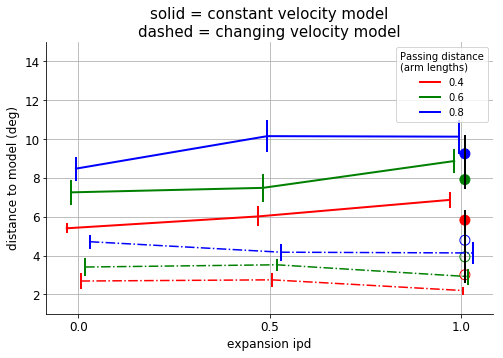

In [16]:
plotSubData = True

##############
nSubs = np.shape(constantVelModel_ipd_pass_bl_sub)[3]
meanConstantVel_ipd_pass_bl  = np.nanmean(constantVelModel_ipd_pass_bl_sub,axis=3)
serConstantVel_ipd_pass_bl = np.nanstd(constantVelModel_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)

meanObserved_ipd_pass_bl  = np.nanmean(observed_ipd_pass_bl_sub,axis=3)
serObserved_ipd_pass_bl = np.nanstd(observed_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = meanConstantVel_ipd_pass_bl[:,pIdx,1]
    yerr = serConstantVel_ipd_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
    x = ipdRatioList + offsets[pIdx+3]
    y = meanObserved_ipd_pass_bl[:,pIdx,1]
    yerr = serObserved_ipd_pass_bl[:,pIdx,1]
    #h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                fmt='-.',color = cList[pIdx])

############ Block 0
bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(meanObserved_ipd_pass_bl[2,:,bIdx]) , 
           y = meanObserved_ipd_pass_bl[2,:,bIdx],
          s=100,facecolors="None",edgecolors=cList)#, markeredgewidth=5)

ax.errorbar(x = [1+.01] * len(meanObserved_ipd_pass_bl[2,:,bIdx]), 
            y = meanObserved_ipd_pass_bl[2,:,bIdx],
            yerr= serObserved_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

ax.scatter(x = [1+.01] * len(meanConstantVel_ipd_pass_bl[2,:,bIdx]) , 
           y = meanConstantVel_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(meanConstantVel_ipd_pass_bl[2,:,bIdx]), 
            y = meanConstantVel_ipd_pass_bl[2,:,bIdx],
            yerr= serConstantVel_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

############


plt.gcf().set_size_inches(8,5)
ax.axes.set_title('solid = constant velocity model\ndashed = changing velocity model', fontsize=15)
ax.set_ylabel('distance to model (deg)', fontsize=12)
ax.set_xlabel('expansion ipd', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([1,15])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=12)

p.set_facecolor('w')

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
fName = outDir + 'meanModelDist.png'
plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)

###  For a single subject

In [19]:
fixDf_expG_bl_sub = allTrialData.groupby(['ipdRatio',
                                          'blockNumber',
                                          'fileName'])

k = fixDf_expG_bl_sub['ballCaughtQ'].groups.keys()
nReps = len(fixDf_expG_bl_sub['ballCaughtQ'].get_group(k[0]))

allTrialData.groupby(['ipdRatio','blockNumber']).groups.keys()
pctCaught_expG_passLoc_bl_sub = fixDf_expG_bl_sub['ballCaughtQ'].agg(np.sum)/nReps*100
pctCaughtB2NoExp_fileName = pctCaught_expG_passLoc_bl_sub[1,2]

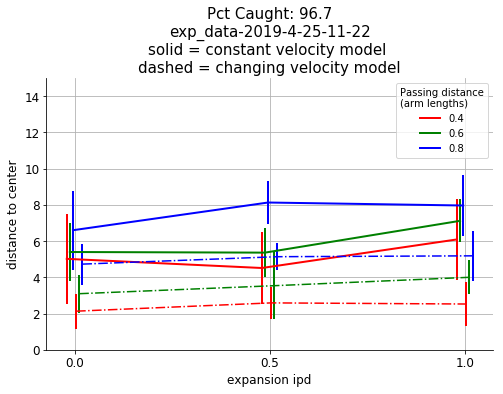

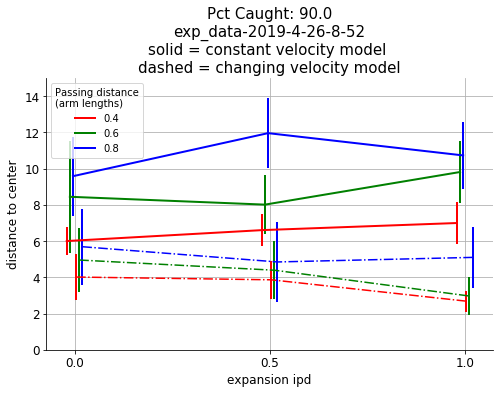

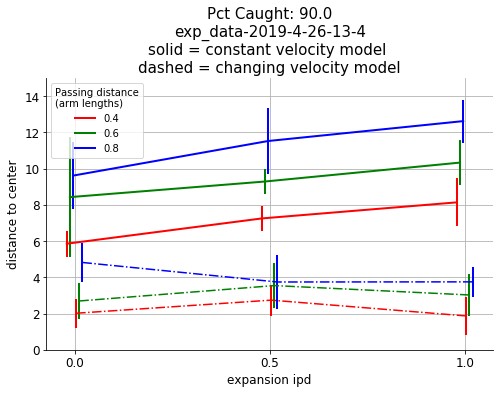

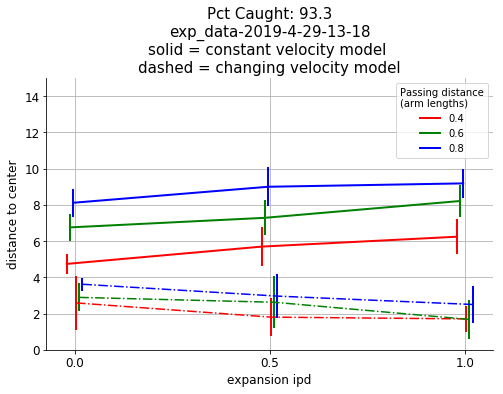

In [20]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];

for subIdx in range(np.shape(constantVelModel_ipd_pass_bl_sub)[3]):

    ##############
    nSubs = np.shape(constantVelModel_ipd_pass_bl_sub)[3]
    meanConstantVel_ipd_pass_bl  = np.squeeze(constantVelModel_ipd_pass_bl_sub[:,:,:,subIdx])
    stdConstantVel_ipd_pass_bl  = np.squeeze(stdConstantVelModel_ipd_pass_bl_sub[:,:,:,subIdx])
    #serConstantVel_ipd_pass_bl = np.std(constantVelModel_ipd_pass_bl_sub[:,:,:,subIdx],axis=3)

    meanObserved_ipd_pass_bl  = np.squeeze(observed_ipd_pass_bl_sub[:,:,:,subIdx])
    stdObserved_ipd_pass_bl  = np.squeeze(stdObserved_ipd_pass_bl_sub[:,:,:,subIdx])
    #serObserved_ipd_pass_bl = np.std(observed_ipd_pass_bl_sub[:,:,:,subIdx],axis=3)

    p, ax = plt.subplots(1, 1) #sharey=True)

    cList = ['r','g','b']
    offsets = np.linspace(-.02,.02,6)
    # Block 2
    for pIdx, pVal in enumerate(passingLocXList):

        x = ipdRatioList + offsets[pIdx]
        y = meanConstantVel_ipd_pass_bl[:,pIdx,1]
        yerr = stdConstantVel_ipd_pass_bl[:,pIdx,1]
        h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
        h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")

        x = ipdRatioList + offsets[pIdx+3]
        y = meanObserved_ipd_pass_bl[:,pIdx,1]
        yerr = stdObserved_ipd_pass_bl[:,pIdx,1]

        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                    fmt='-.',color = cList[pIdx])


    plt.gcf().set_size_inches(8,5)
    pctCaught = pctCaughtB2NoExp_fileName[fileNames[subIdx]]
    titleStr = 'Pct Caught: {0:.1f}\n{1:}\nsolid = constant velocity model \ndashed = changing velocity model'.format(pctCaught,fileNames[subIdx])
    ax.axes.set_title(titleStr, fontsize=15)
    #ax.axes.set_title('Pct Caught: ' +  fileNames[subIdx]  + '\nsolid = velocity model \n dashed = actual trajectory', fontsize=15)
    
    ax.set_ylabel('distance to center', fontsize=12)
    ax.set_xlabel('expansion ipd', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_ylim([0,15])
    plt.legend(title='Passing distance\n(arm lengths)')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    ax.axes.set_axisbelow(True)

    plt.rcParams["font.family"] = "sans-serif"
    ax.set_xticks(ipdRatioList)
    ax.tick_params(axis='both', which='major', labelsize=12)

    #plt.title()
    p.set_facecolor('w')
    
    outDir = '../subFigs/'
    if not os.path.exists(outDir):
        os.makedirs(outDir)

    fName = outDir + 'gazeModel_' + fileTimeList[subIdx] + '.png'
    plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)


# Mean normalized location

In [ ]:
# normLocInWindow_gain_pass_bl_sub[:,2,:,0]

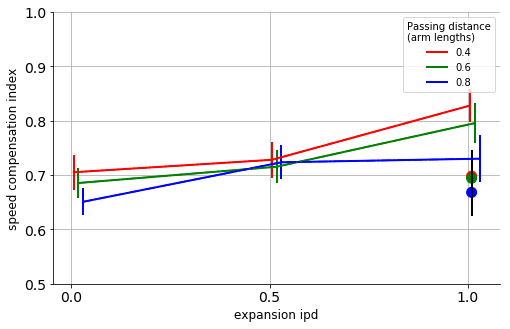

In [21]:
plotSubData = True

##############
nSubs = np.shape(constantVelModel_ipd_pass_bl_sub)[3]
normLocInWindow_ipd_pass_bl  = np.nanmean(normLocInWindow_ipd_pass_bl_sub,axis=3)
serNormLocInWindow_ipd_pass_bl = np.nanstd(normLocInWindow_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx+3]
    y = normLocInWindow_ipd_pass_bl[:,pIdx,1]
    yerr = serNormLocInWindow_ipd_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                fmt='-.',color = cList[pIdx])

############ Block 0
bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(normLocInWindow_ipd_pass_bl[2,:,bIdx]) , 
           y = normLocInWindow_ipd_pass_bl[2,:,bIdx],
           s=100,facecolors=cList,edgecolors=cList)

ax.errorbar(x = [1+.01] * len(normLocInWindow_ipd_pass_bl[2,:,bIdx]), 
            y = normLocInWindow_ipd_pass_bl[2,:,bIdx],
            yerr= serNormLocInWindow_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

############

plt.gcf().set_size_inches(8,5)

ax.set_ylabel('speed compensation index', fontsize=12)
ax.set_xlabel('expansion ipd', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([.5,1])
#ax.set_ylim([.3,.7])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=14)

p.set_facecolor('w')

# ax.axhline(.5, c='k',ls=':',xmin=0, xmax=1,lw=3)

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)
    
fName = outDir + 'distAlongContinuum.png'
plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)


# Normalized location for each subject

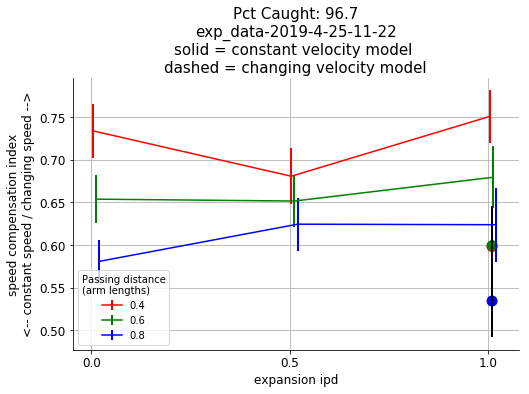

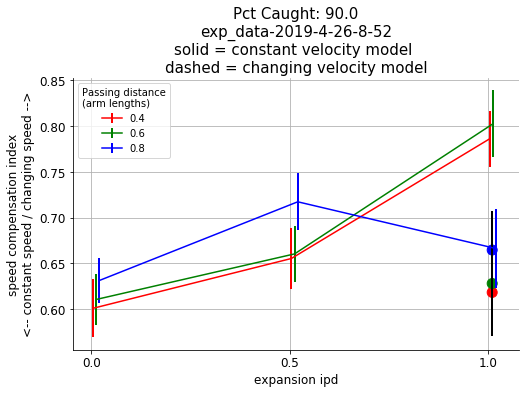

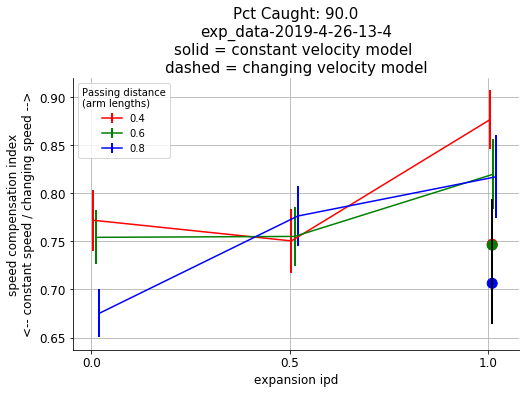

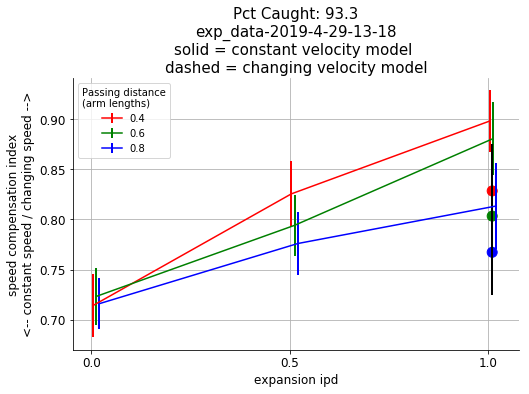

In [22]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];

for subIdx in range(np.shape(constantVelModel_ipd_pass_bl_sub)[3]):

    ##############
    nSubs = np.shape(constantVelModel_ipd_pass_bl_sub)[3]
    normLocInWindow_ipd_pass_bl  = np.squeeze(normLocInWindow_ipd_pass_bl_sub[:,:,:,subIdx])
    stdNormLocInWindow_ipd_pass_bl  = np.squeeze(stdNormLocInWindow_ipd_pass_bl_sub[:,:,:,subIdx])

    p, ax = plt.subplots(1, 1) #sharey=True)

    cList = ['r','g','b']
    offsets = np.linspace(-.02,.02,6)
    # Block 2
    for pIdx, pVal in enumerate(passingLocXList):
        
        x = ipdRatioList + offsets[pIdx+3]
        y = normLocInWindow_ipd_pass_bl[:,pIdx,1]
        yerr = serNormLocInWindow_ipd_pass_bl[:,pIdx,1]
        
        h = ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],
                    fmt='-',color = cList[pIdx])
        h.set_label(pVal)

    ############ Block 0
    bIdx = 0
    cList = ['r','g','b']

    ax.scatter(x = [1+.01] * len(normLocInWindow_ipd_pass_bl[2,:,bIdx]) , 
               y = normLocInWindow_ipd_pass_bl[2,:,bIdx],
              s=100,facecolors=cList,edgecolors=cList)#, markeredgewidth=5)

    ax.errorbar(x = [1+.01] * len(normLocInWindow_ipd_pass_bl[2,:,bIdx]), 
                y = normLocInWindow_ipd_pass_bl[2,:,bIdx],
                yerr= serNormLocInWindow_ipd_pass_bl[2,:,bIdx] ,
                elinewidth=2,
                ecolor = 'k',fmt="none")
    
#     ax.axhline(.5, c='k',ls=':',xmin=0, xmax=1,lw=3)
    
    ############

    plt.gcf().set_size_inches(8,5)
    pctCaught = pctCaughtB2NoExp_fileName[fileNames[subIdx]]
    titleStr = 'Pct Caught: {0:.1f}\n{1:}\nsolid = constant velocity model \ndashed = changing velocity model'.format(pctCaught,fileNames[subIdx])
    ax.axes.set_title(titleStr, fontsize=15)
    
    ax.set_ylabel('speed compensation index\n<-- constant speed / changing speed -->', fontsize=12)
    ax.set_xlabel('expansion ipd', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

#     ax.set_ylim([.5,1.5])
    plt.legend(title='Passing distance\n(arm lengths)')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    ax.axes.set_axisbelow(True)

    plt.rcParams["font.family"] = "sans-serif"
    ax.set_xticks(ipdRatioList)
    ax.tick_params(axis='both', which='major', labelsize=12)

    p.set_facecolor('w')
    
    outDir = '../subFigs/'
    if not os.path.exists(outDir):
        os.makedirs(outDir)

    fName = outDir + 'gazeContinuum_' + fileTimeList[subIdx] + '.png'
    plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)
